In [131]:
import pandas as pd
import numpy as np
from sklearn.externals import joblib
import nltk
import gensim
import spacy

from sklearn import metrics

import torch as tt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchtext.data import Field, LabelField, BucketIterator, TabularDataset, Iterator



SEED = 42
np.random.seed(SEED)

In [ ]:
model_path = r"all.norm-sz100-w10-cb0-it1-min100.w2v"
model_w = KeyedVectors.load_word2vec_format(model_path, binary=True, unicode_errors='ignore')

In [23]:
df = pd.read_csv('imdb_master_utf.csv', index_col=0)
df.head()

,type,review,label,file
0,test,Once again Mr. Costner has dragged out a movie...,neg,0_2.txt
1,test,This is an example of why the majority of acti...,neg,10000_4.txt
2,test,"First of all I hate those moronic rappers, who...",neg,10001_1.txt
3,test,Not even the Beatles could write songs everyon...,neg,10002_3.txt
4,test,Brass pictures (movies is not a fitting word f...,neg,10003_3.txt


In [24]:
train_df = df[df.type == 'train']
test_df = df[df.type == 'test']

In [29]:
train_df[['review','label']].to_csv('train.csv', index=False)
test_df[['review','label']].to_csv('test.csv', index=False)

In [25]:
train_df.shape

(75000, 4)

In [26]:
test_df.shape

(25000, 4)

In [14]:
import spacy


spacy_en = spacy.load('en')

def tokenizer(text): # create a tokenizer function
    return [tok.text for tok in spacy_en.tokenizer(text) if tok.text.isalpha()]            

In [30]:
train_df.head()

,type,review,label,file
25000,train,Story of a man who has unnatural feelings for ...,neg,0_3.txt
25001,train,Airport '77 starts as a brand new luxury 747 p...,neg,10000_4.txt
25002,train,This film lacked something I couldn't put my f...,neg,10001_4.txt
25003,train,"Sorry everyone,,, I know this is supposed to b...",neg,10002_1.txt
25004,train,When I was little my parents took me along to ...,neg,10003_1.txt


In [32]:
classes={
    'neg':0,
    'unsup':1,
    'pos':2
}

TEXT = Field(include_lengths=True, batch_first=True, 
             tokenize=tokenizer,
             eos_token='<eos>',
             lower=True,
             stop_words=nltk.corpus.stopwords.words('english'))

LABEL = LabelField(dtype=tt.int64, use_vocab=True, preprocessing=lambda x: classes[x])

dataset = TabularDataset('imdb_master_utf.csv', format='csv', 
                             fields=[(None, None),(None, None),('review', TEXT), ('label', LABEL), (None, None)], 
                             skip_header=True, csv_reader_params={'dialect':'excel'})

In [33]:
#TEXT.build_vocab(dataset, min_freq=10, vectors="glove.6B.100d")
TEXT.build_vocab(dataset, min_freq=5)
len(TEXT.vocab.itos)

52212

In [34]:
TEXT.vocab.itos[:10]

['<unk>',
 '<pad>',
 '<eos>',
 'movie',
 'film',
 'one',
 'like',
 'good',
 'would',
 'even']

In [35]:
LABEL.build_vocab(dataset)

In [36]:
train, test = dataset.split(0.7, stratified=True)
train, valid = train.split(0.7, stratified=True)

In [37]:
np.unique([x.label for x in train.examples], return_counts=True)

(array([0, 1, 2]), array([12250, 24500, 12250], dtype=int64))

In [38]:
np.unique([x.label for x in valid.examples], return_counts=True)

(array([0, 1, 2]), array([ 5250, 10500,  5250], dtype=int64))

In [39]:
np.unique([x.label for x in test.examples], return_counts=True)

(array([0, 1, 2]), array([ 7500, 15000,  7500], dtype=int64))

In [201]:
crit_loss = []

In [211]:
def evaluate(test_iterator, criterion):
    loss = 0
    with tt.no_grad():
        for batch in test_iterator:
            pred = model.forward(batch.review[0], None)
            test = criterion(pred, batch.label)
            loss += test
    crit = loss / len(test_iterator)
                    
    return crit

## Way 1

In [93]:
w2v_model_1 = gensim.models.KeyedVectors.load_word2vec_format('news_0_300_2.bin', binary = True)

In [94]:
weights = tt.FloatTensor(w2v_model_1.vectors)

In [202]:
class MyModel(nn.Module):
    
    def __init__(self, vocab_size, embed_size, hidden_size, kernels, embed_matrix):
        super(MyModel, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(embed_matrix, freeze=True)
        self.convs = nn.ModuleList([nn.Conv1d(embed_size, hidden_size, k, padding=5) for k in kernels])
        self.fc = nn.Linear(hidden_size * len(kernels), 3)
        
    def forward(self, x, x_lengths):
        
        x = self.embedding(x)
        x = x.transpose(1,2)
        
        concatenated = []
        for conv in self.convs:
            z = conv(x)
            z = F.avg_pool1d(z, kernel_size=z.size(2)) #maxpooling, RELU, ELU
            z = z.squeeze(2)
            concatenated.append(z)
            
        x = tt.cat(concatenated, 1)
        x = self.fc(x)
        return x

In [203]:
tt.cuda.empty_cache()

batch_size = 32

model = MyModel(len(TEXT.vocab.itos),
                embed_size=300,
                hidden_size=128,
                kernels=[2,3,4,5],
                embed_matrix=weights
               )

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train, valid, test),
    batch_sizes=(batch_size, batch_size, batch_size),
    shuffle=True,
    sort_key=lambda x: len(x.review)
#     sort_within_batch=True,
)

optimizer = optim.Adam(model.parameters())
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, verbose=True, cooldown=5)
criterion = nn.CrossEntropyLoss()

In [139]:
early_k = 0
min_loss = float('inf')
n_epochs = 1000
a = []


for i in range(n_epochs):
    loss = 0
    for batch in train_iterator:
        optimizer.zero_grad()
        pred = model.forward(batch.review[0], None)
        l = criterion(pred, batch.label)
        loss += l.item()
        l.backward()
        optimizer.step()
    loss_train = loss / len(train_iterator)

    loss_v = 0
    with tt.no_grad():
        for batch in valid_iterator:
            pred = model.forward(batch.review[0], None)
            loss_v += criterion(pred, batch.label)

    loss = loss_v / len(valid_iterator)
    a.append(optimizer.param_groups[0]['lr'])

    if loss < min_loss:
        min_loss = loss
        early_k = 0
    else:
        early_k += 1
    if early_k > 10:
        break
    print('Epoch: ' + str(i))
    scheduler.step(loss)


Epoch: 0
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch     8: reducing learning rate of group 0 to 1.0000e-04.
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12


In [151]:
a

[0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.0001,
 0.0001,
 0.0001,
 0.0001,
 0.0001]

In [129]:
len(a)

15

In [126]:
from matplotlib import pyplot as plt
% matplotlib inline

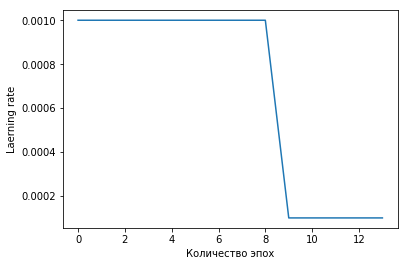

In [189]:
plt.plot(range(0, len(a)), a)
plt.xlabel('Количество эпох')
plt.ylabel('Laerning rate');

In [212]:
crit_loss.append(evaluate(test_iterator, criterion))

## Way 2

In [154]:
data = pd.read_csv('Tweets.csv')
data.head()

,tweet_id,airline_sentiment,airline,retweet_count,text
0,570306133677760513,neutral,Virgin America,0,@VirginAmerica What @dhepburn said.
1,570301130888122368,positive,Virgin America,0,@VirginAmerica plus you've added commercials t...
2,570301083672813571,neutral,Virgin America,0,@VirginAmerica I didn't today... Must mean I n...
3,570301031407624196,negative,Virgin America,0,@VirginAmerica it's really aggressive to blast...
4,570300817074462722,negative,Virgin America,0,@VirginAmerica and it's a really big bad thing...


In [155]:
tweets = []

for tweet in data['text']:
    tweets.append(gensim.utils.simple_preprocess(tweet))

In [169]:
w2v_model_2 = gensim.models.Word2Vec(
        tweets,
        size=300,
        window=10,
        min_count=2,
        workers=10)
w2v_model_2.train(tweets, total_examples=len(tweets), epochs=10)

(1780266, 2441730)

In [170]:
weights_2 = tt.FloatTensor(w2v_model_2.wv.syn0)

C:\Users\1\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).
  """Entry point for launching an IPython kernel.


In [171]:
weights_2.shape

torch.Size([5995, 300])

In [167]:
weights.shape

torch.Size([124590, 300])

In [215]:
class MyModel(nn.Module):
    
    def __init__(self, vocab_size, embed_size, hidden_size, kernels, embed_matrix):
        super(MyModel, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(embed_matrix, freeze=False)
        self.convs = nn.ModuleList([nn.Conv1d(embed_size, hidden_size, k, padding=5) for k in kernels])
        self.fc = nn.Linear(hidden_size * len(kernels), 3)
        
    def forward(self, x, x_lengths):
        
        x = self.embedding(x)
        x = x.transpose(1,2)
        
        concatenated = []
        for conv in self.convs:
            z = conv(x)
            z = F.avg_pool1d(z, kernel_size=z.size(2)) #maxpooling, RELU, ELU
            z = z.squeeze(2)
            concatenated.append(z)
            
        x = tt.cat(concatenated, 1)
        x = self.fc(x)
        return x

In [216]:
tt.cuda.empty_cache()

batch_size = 32

model = MyModel(len(TEXT.vocab.itos),
                embed_size=300,
                hidden_size=128,
                kernels=[2,3,4,5],
                embed_matrix=weights
               )

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train, valid, test),
    batch_sizes=(batch_size, batch_size, batch_size),
    shuffle=True,
    sort_key=lambda x: len(x.review)
#     sort_within_batch=True,
)

optimizer = optim.Adam(model.parameters())
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, verbose=True, cooldown=5)
criterion = nn.CrossEntropyLoss()

In [185]:
early_k = 0
min_loss = float('inf')
n_epochs = 1000
b = []


for i in range(n_epochs):
    loss = 0
    for batch in train_iterator:
        optimizer.zero_grad()
        pred = model.forward(batch.review[0], None)
        l = criterion(pred, batch.label)
        loss += l.item()
        l.backward()
        optimizer.step()
    loss_train = loss / len(train_iterator)

    loss_v = 0
    with tt.no_grad():
        for batch in valid_iterator:
            pred = model.forward(batch.review[0], None)
            loss_v += criterion(pred, batch.label)

    loss = loss_v / len(valid_iterator)
    b.append(optimizer.param_groups[0]['lr'])

    if loss < min_loss:
        min_loss = loss
        early_k = 0
    else:
        early_k += 1
    if early_k > 10:
        break
    print('Epoch: ' + str(i))
    scheduler.step(loss)


Epoch: 0
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch     6: reducing learning rate of group 0 to 1.0000e-04.
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10


In [186]:
b

[0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.0001,
 0.0001,
 0.0001,
 0.0001,
 0.0001]

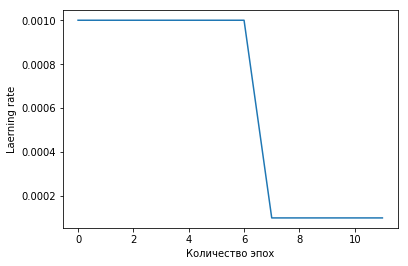

In [191]:
plt.plot(range(0, len(b)), b)
plt.xlabel('Количество эпох')
plt.ylabel('Laerning rate');

In [217]:
crit_loss.append(evaluate(test_iterator, criterion))

## Way 3

In [218]:
class MyModel(nn.Module):
    
    def __init__(self, vocab_size, embed_size, hidden_size, kernels, embed_matrix):
        super(MyModel, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(nn.init.uniform_(tt.ones((vocab_size,300))), freeze=False)
        self.convs = nn.ModuleList([nn.Conv1d(embed_size, hidden_size, k, padding=5) for k in kernels])
        self.fc = nn.Linear(hidden_size * len(kernels), 3)
        
    def forward(self, x, x_lengths):
        
        x = self.embedding(x)
        x = x.transpose(1,2)
        
        concatenated = []
        for conv in self.convs:
            z = conv(x)
            z = F.avg_pool1d(z, kernel_size=z.size(2)) #maxpooling, RELU, ELU
            z = z.squeeze(2)
            concatenated.append(z)
            
        x = tt.cat(concatenated, 1)
        x = self.fc(x)
        return x

In [219]:
tt.cuda.empty_cache()

batch_size = 32

model = MyModel(len(TEXT.vocab.itos),
                embed_size=300,
                hidden_size=128,
                kernels=[2,3,4,5],
                embed_matrix=weights
               )

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train, valid, test),
    batch_sizes=(batch_size, batch_size, batch_size),
    shuffle=True,
    sort_key=lambda x: len(x.review)
#     sort_within_batch=True,
)

optimizer = optim.Adam(model.parameters())
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, verbose=True, cooldown=5)
criterion = nn.CrossEntropyLoss()

In [196]:
early_k = 0
min_loss = float('inf')
n_epochs = 1000
c = []


for i in range(n_epochs):
    loss = 0
    for batch in train_iterator:
        optimizer.zero_grad()
        pred = model.forward(batch.review[0], None)
        l = criterion(pred, batch.label)
        loss += l.item()
        l.backward()
        optimizer.step()
    loss_train = loss / len(train_iterator)

    loss_v = 0
    with tt.no_grad():
        for batch in valid_iterator:
            pred = model.forward(batch.review[0], None)
            loss_v += criterion(pred, batch.label)

    loss = loss_v / len(valid_iterator)
    c.append(optimizer.param_groups[0]['lr'])

    if loss < min_loss:
        min_loss = loss
        early_k = 0
    else:
        early_k += 1
    if early_k > 10:
        break
    print('Epoch: ' + str(i))
    scheduler.step(loss)

Epoch: 0
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch     6: reducing learning rate of group 0 to 1.0000e-04.
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10


In [197]:
c

[0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.0001,
 0.0001,
 0.0001,
 0.0001,
 0.0001]

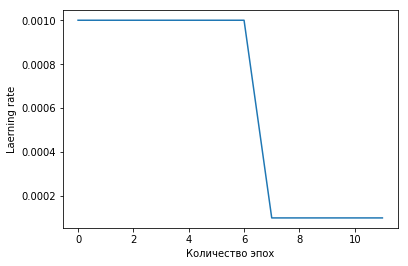

In [198]:
plt.plot(range(0, len(c)), c)
plt.xlabel('Количество эпох')
plt.ylabel('Laerning rate');

In [220]:
crit_loss.append(evaluate(test_iterator, criterion))

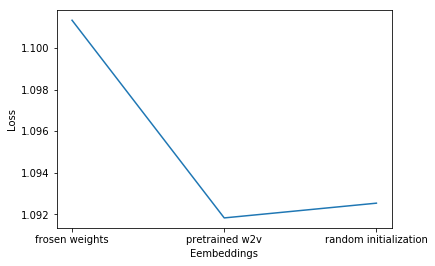

In [225]:
plt.plot(['frosen weights', 'pretrained w2v', 'random initialization'], 
         [crit_loss[0].item(), crit_loss[1].item(), crit_loss[2].item()])
plt.xlabel('Eembeddings')
plt.ylabel('Loss');